**Connect Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git -C ERA_V1 pull
#!cd ../
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git -C dl_hub pull
!git pull

!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts" "torchtext" "datasets" "tokenizers" "transformers"

Cloning into 'ERA_V1'...
remote: Enumerating objects: 1487, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 1487 (delta 27), reused 27 (delta 4), pack-reused 1407
Receiving objects: 100% (1487/1487), 201.35 MiB | 32.05 MiB/s, done.
Resolving deltas: 100% (719/719), done.
Already up to date.
Cloning into 'dl_hub'...
remote: Enumerating objects: 581, done.
remote: Counting objects: 100% (333/333), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 581 (delta 215), reused 291 (delta 183), pack-reused 248
Receiving objects: 100% (581/581), 161.26 KiB | 3.84 MiB/s, done.
Resolving deltas: 100% (359/359), done.
Already up to date.
fatal: not a git repository (or any of the parent directories): .git
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8

**Imports**

In [13]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torchvision import transforms
from dl_hub.transformer_models.vit_utils import data_setup, engine, utils
from dl_hub.transformer_models.transformer_models import ViT
from dl_hub.transformer_models.vit_utils.utils import plot_loss_curves


from torch import nn
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"


In [4]:
image_path = "/content/gdrive/MyDrive/Datasets/PizzaSteakSushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


**Show a sample image**

(-0.5, 223.5, 223.5, -0.5)

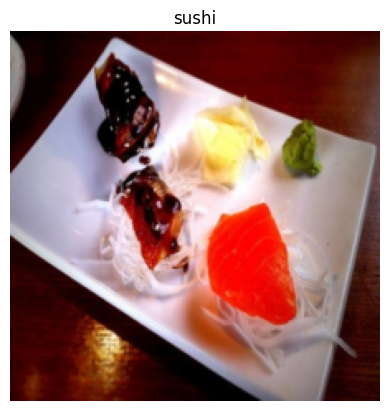

In [5]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)


**Pre process image into patches and create embeddings**

In [6]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [7]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.3064,  0.4608, -0.2446]], grad_fn=<AddmmBackward0>)

In [8]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─EncoderBlock (0)                                      

In [12]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=4,
                       device=device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.5289 | train_acc: 0.2695 | test_loss: 3.8265 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.6450 | train_acc: 0.2500 | test_loss: 1.4441 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.2066 | train_acc: 0.2891 | test_loss: 1.1573 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1235 | train_acc: 0.2891 | test_loss: 1.3282 | test_acc: 0.2604


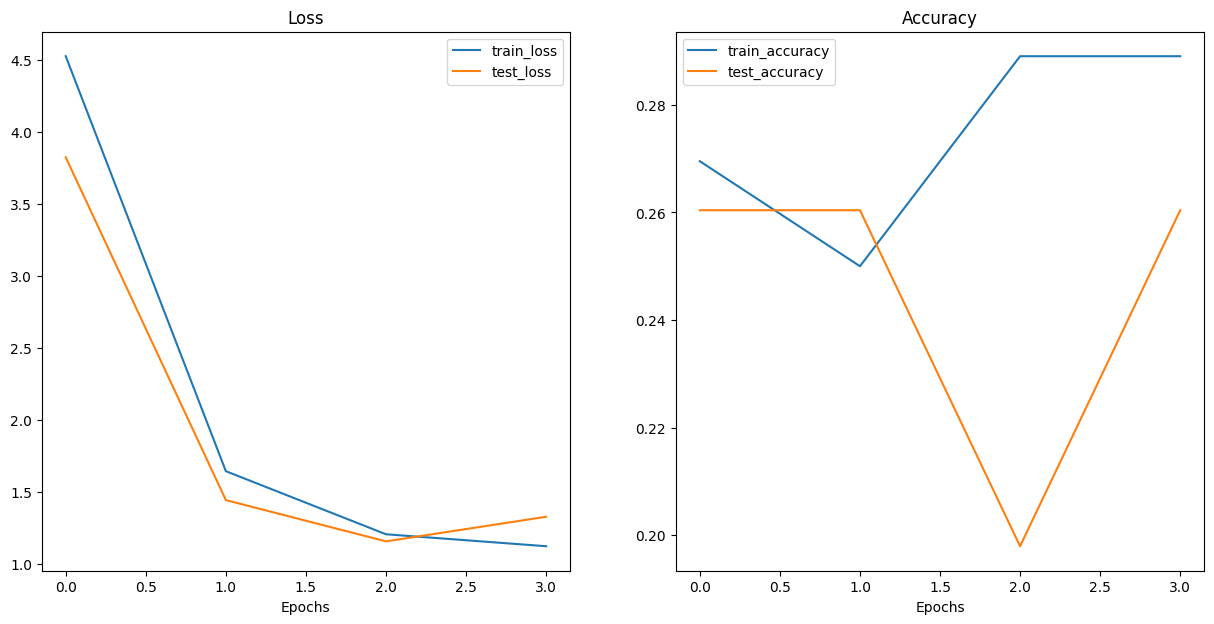

In [14]:
# Plot our ViT model's loss curves
plot_loss_curves(results)

In [15]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:06<00:00, 57.4MB/s]


In [16]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [17]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [18]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [19]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=3,
                                      device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8127 | train_acc: 0.7266 | test_loss: 0.4998 | test_acc: 0.9081
Epoch: 2 | train_loss: 0.3373 | train_acc: 0.9375 | test_loss: 0.3418 | test_acc: 0.8883
Epoch: 3 | train_loss: 0.2103 | train_acc: 0.9492 | test_loss: 0.2525 | test_acc: 0.9186


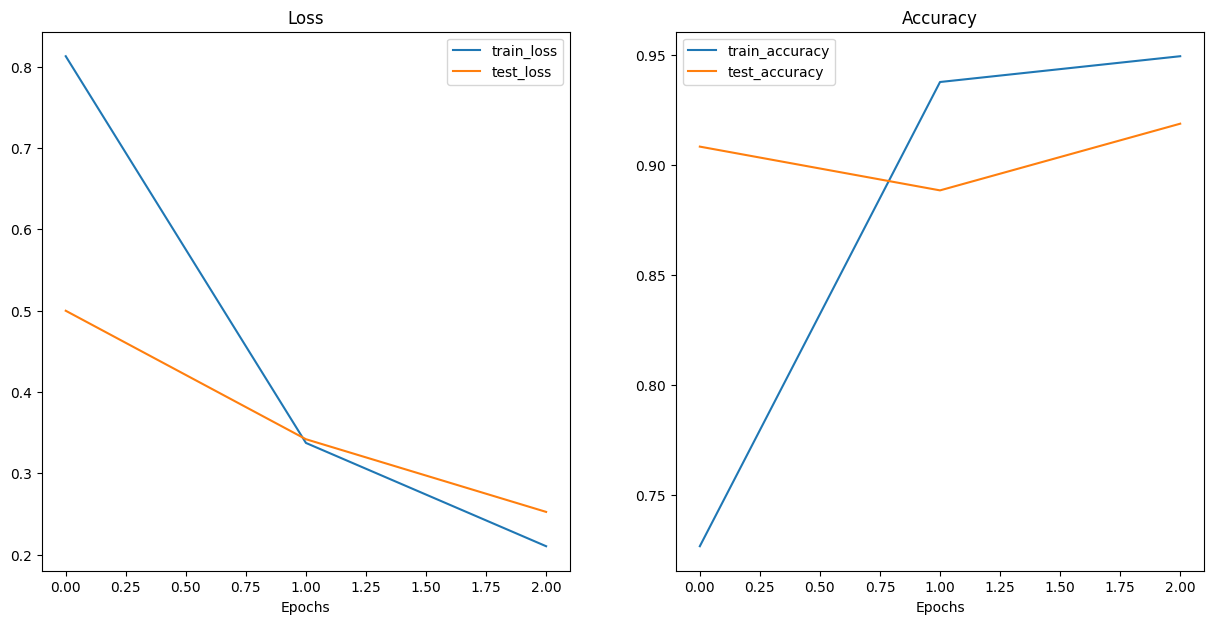

In [20]:
plot_loss_curves(pretrained_vit_results)

In [21]:
# Save the model
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [22]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


Downloading...


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


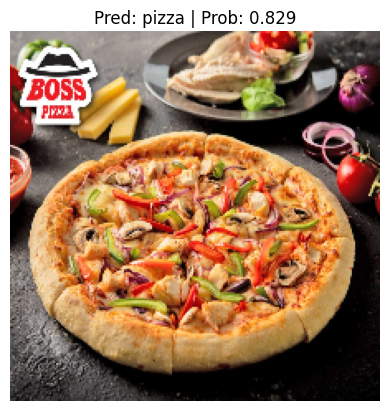

In [23]:
import requests

with open("download.jpeg", "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://www.boss-pizza.co.uk/site/assets/images/uploads/2_3_5c232a9d83be_o.jpg")
    print(f"Downloading...")
    f.write(request.content)

# Predict on custom image
utils.pred_and_plot_image(model=pretrained_vit,
                    image_path="download.jpeg",
                    transform=transforms.Resize((IMG_SIZE, IMG_SIZE)),
                    class_names=class_names)